# Intro to Neural Networks

## Assignment 3

### Mohsin Mohammed


In [73]:
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import numpy as np
import xgboost as xgb
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix
import random
from PIL import Image
from keras.preprocessing import image

###  1.Perform necessary pre-processing

In [3]:
# Lets unzip the folder
def unzip_dataset(zip_path, output_dir):
    """
    Unzips the provided dataset into the specified output directory.
    
    Parameters:
    zip_path: Path to the zipped dataset.
    output_dir: Directory where the dataset will be extracted.
    
    Returns:
    List folders extracted.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_files:
        zip_files.extractall(output_dir)

    extracted_files = os.listdir(output_dir)
    return extracted_files




In [4]:
# unzippping the dataset:
data = unzip_dataset('./dataset.zip', './data')
data

['dataset']

In [5]:
# Lets explore the files within the dataset folder that we just unzipped
open_dataset = os.listdir('./data/dataset')
open_dataset

['testing', 'training']

In [6]:
# Training data:
training_data = os.listdir('./data/dataset/training')
training_data

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [7]:
# Testing data:
testing_data  = os.listdir('./data/dataset/testing')
testing_data

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [9]:
# Lets count the number of images from each category from the train set
train_image_count = {category: len(os.listdir(f'./data/dataset/training/{category}')) for category in training_data}
train_image_count

{'buildings': 38,
 'forest': 22,
 'glacier': 32,
 'mountain': 28,
 'sea': 34,
 'street': 55}

In [10]:
# Lets count the number of images from each category from the test set
test_image_count = {category: len(os.listdir(f'./data/dataset/testing/{category}')) for category in testing_data}
test_image_count

{'buildings': 961,
 'forest': 1038,
 'glacier': 1033,
 'mountain': 1201,
 'sea': 1076,
 'street': 773}

A visual inspection of the count of images looks like we have more images in the test set than we do in the train set. It should be the other way around. We can also plot this information to help us see this clearly:

In [12]:
# Since we already have the count of all the images in a dictionary , we can sum all these numbers up and save it to a variable which we can use to plot the count of images in the train and test sets
training_images_count = sum(train_image_count.values())
testing_images_count = sum(test_image_count.values())

print(f"There are a total of {training_images_count} images in the training set")
print(f"There are a total of {testing_images_count} images in the testing set")

There are a total of 209 images in the training set
There are a total of 6082 images in the testing set


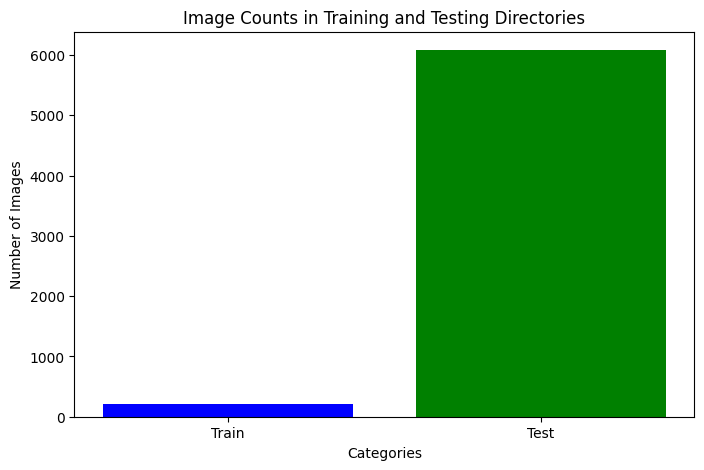

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(["Train", "Test"], [training_images_count, testing_images_count], color=['blue', 'green'])
plt.title("Image Counts in Training and Testing Directories")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
# plt.tight_layout()

plt.show()

In [17]:
# It looks like the folder that was provided was misclassified because we have significantly more images in the test set and a mere fraction of that in the train set. We usually have the opposite.
# This looks like a mistake so lets rename the folders:
os.rename('./data/dataset/training', './data/dataset/test')
os.rename('./data/dataset/testing', './data/dataset/train')


# We have now changed the name of the folders to train and test respectively. However, we will have to reassigng our train and test data to reflect the correct folders.

In [18]:
# Lets rewrite our code for the appropriate folders: 

train_data = os.listdir('./data/dataset/train')
test_data = os.listdir('./data/dataset/test')

train_image_count = {category: len(os.listdir(f'./data/dataset/train/{category}')) for category in train_data}

test_image_count = {category : len(os.listdir(f'./data/dataset/test/{category}')) for category in test_data}




In [21]:
train_image_count

{'buildings': 961,
 'forest': 1038,
 'glacier': 1033,
 'mountain': 1201,
 'sea': 1076,
 'street': 773}

In [22]:
test_image_count

{'buildings': 38,
 'forest': 22,
 'glacier': 32,
 'mountain': 28,
 'sea': 34,
 'street': 55}

In [24]:
train_images_count = sum(train_image_count.values())
test_images_count = sum(test_image_count.values())

print(f"There are a total of {train_images_count} images in the training set")
print(f"There are a total of {test_images_count} images in the testing set")

There are a total of 6082 images in the training set
There are a total of 209 images in the testing set


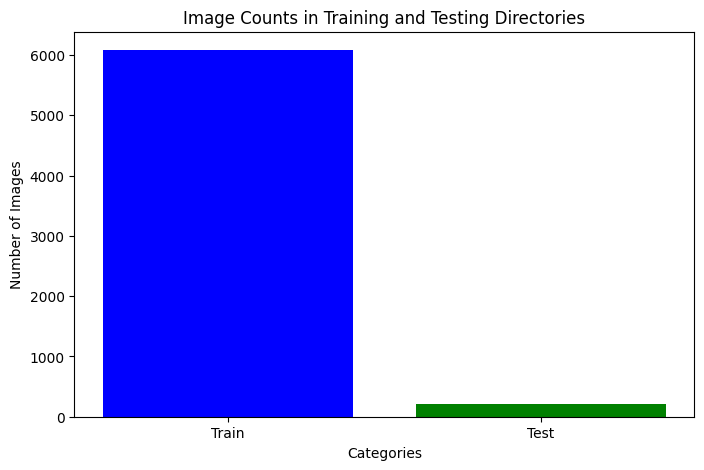

In [25]:
plt.figure(figsize=(8, 5))
plt.bar(["Train", "Test"], [train_images_count, test_images_count], color=['blue', 'green'])
plt.title("Image Counts in Training and Testing Directories")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
# plt.tight_layout()

plt.show()



In [33]:
# We have now taken care of the folder structure. lets go ahead and plot their distribution:

def plot_count_frequency(count_dict):
    keys = count_dict.keys()
    values = count_dict.values()
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values)
    plt.title("Count plot of the images")
    plt.xlabel('Images')
    plt.xticks(rotation=45)
    plt.ylabel('count of Images')
    plt.show()

    

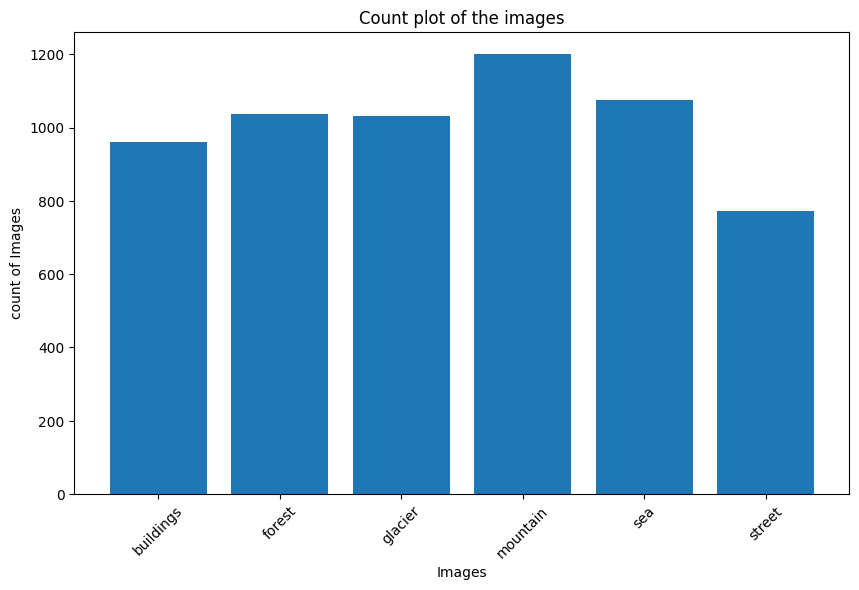

In [34]:
# training data count plot
plot_count_frequency(train_image_count)

 It looks like our training data follows a uniform distribution with slightly more images of mountains.

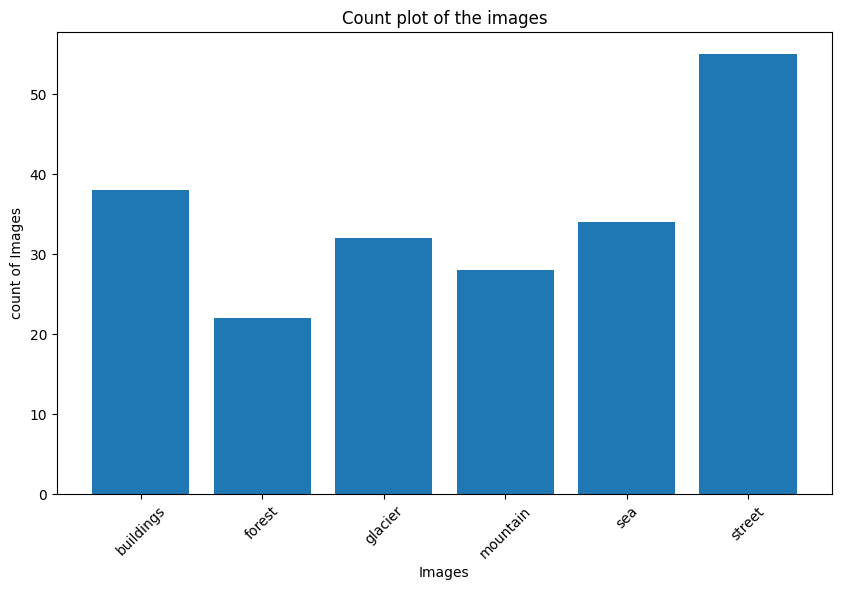

In [35]:
# Lets plot the test count plot
plot_count_frequency(test_image_count)

In [75]:
# Function to get random images dimensions from a directory
def get_random_image_dimensions(directory, num_images=5):
    all_images = [img for img in os.listdir(directory) if img.endswith(('.jpg'))]
    selected_images = random.sample(all_images, num_images)
    dimensions = []

    for img_name in selected_images:
        with Image.open(os.path.join(directory, img_name)) as img:
            dimensions.append(img.size)

    return dimensions



### Lets analyze the test subdirectories for the image dimensions and pixel intensities.

In [76]:
test_path = "./data/dataset/test"
test_subdirs =  [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]

print(f"The subdirectories within the test set are: {test_subdirs}")

The subdirectories within the test set are: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)


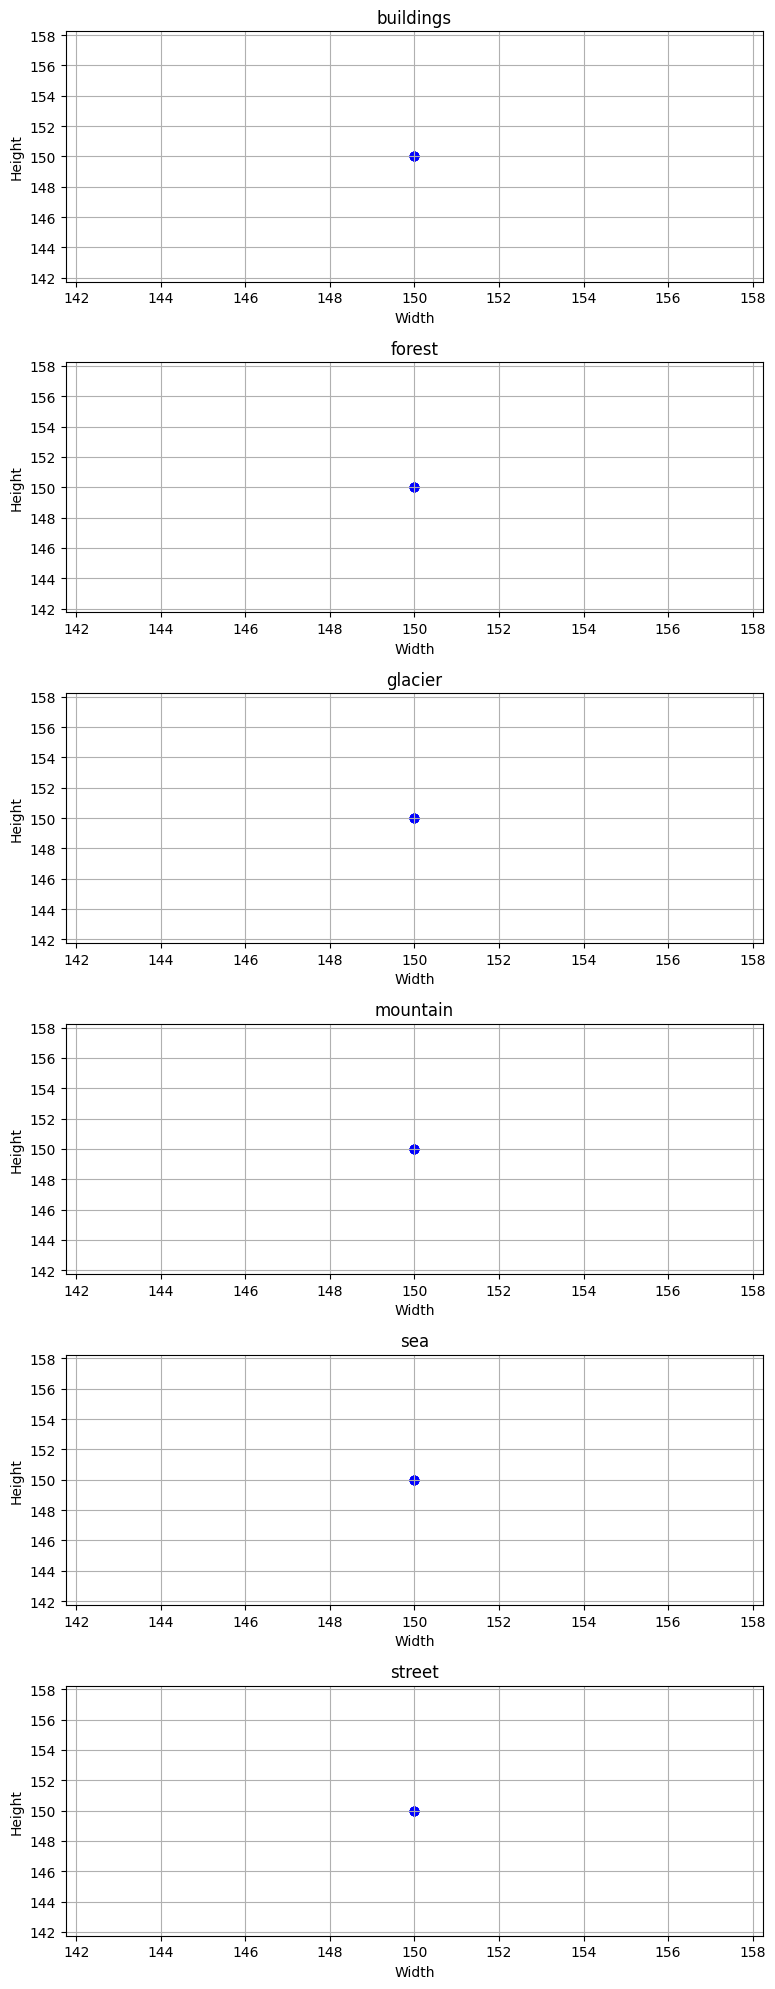

In [79]:
# Extracting image dimensions from each sub-directory
image_dimensions = {}
for subdir in test_subdirs:
    image_dimensions[subdir] = get_random_image_dimensions(os.path.join(test_path, subdir))

# Plotting the dimensions
fig, axs = plt.subplots(len(test_subdirs), 1, figsize=(8, 20))
for i, (subdir, dimensions) in enumerate(image_dimensions.items()):
    widths, heights = zip(*dimensions)
    print(widths, heights)
    axs[i].scatter(widths, heights, color='blue')
    axs[i].set_title(subdir)
    axs[i].set_xlabel('Width')
    axs[i].set_ylabel('Height')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

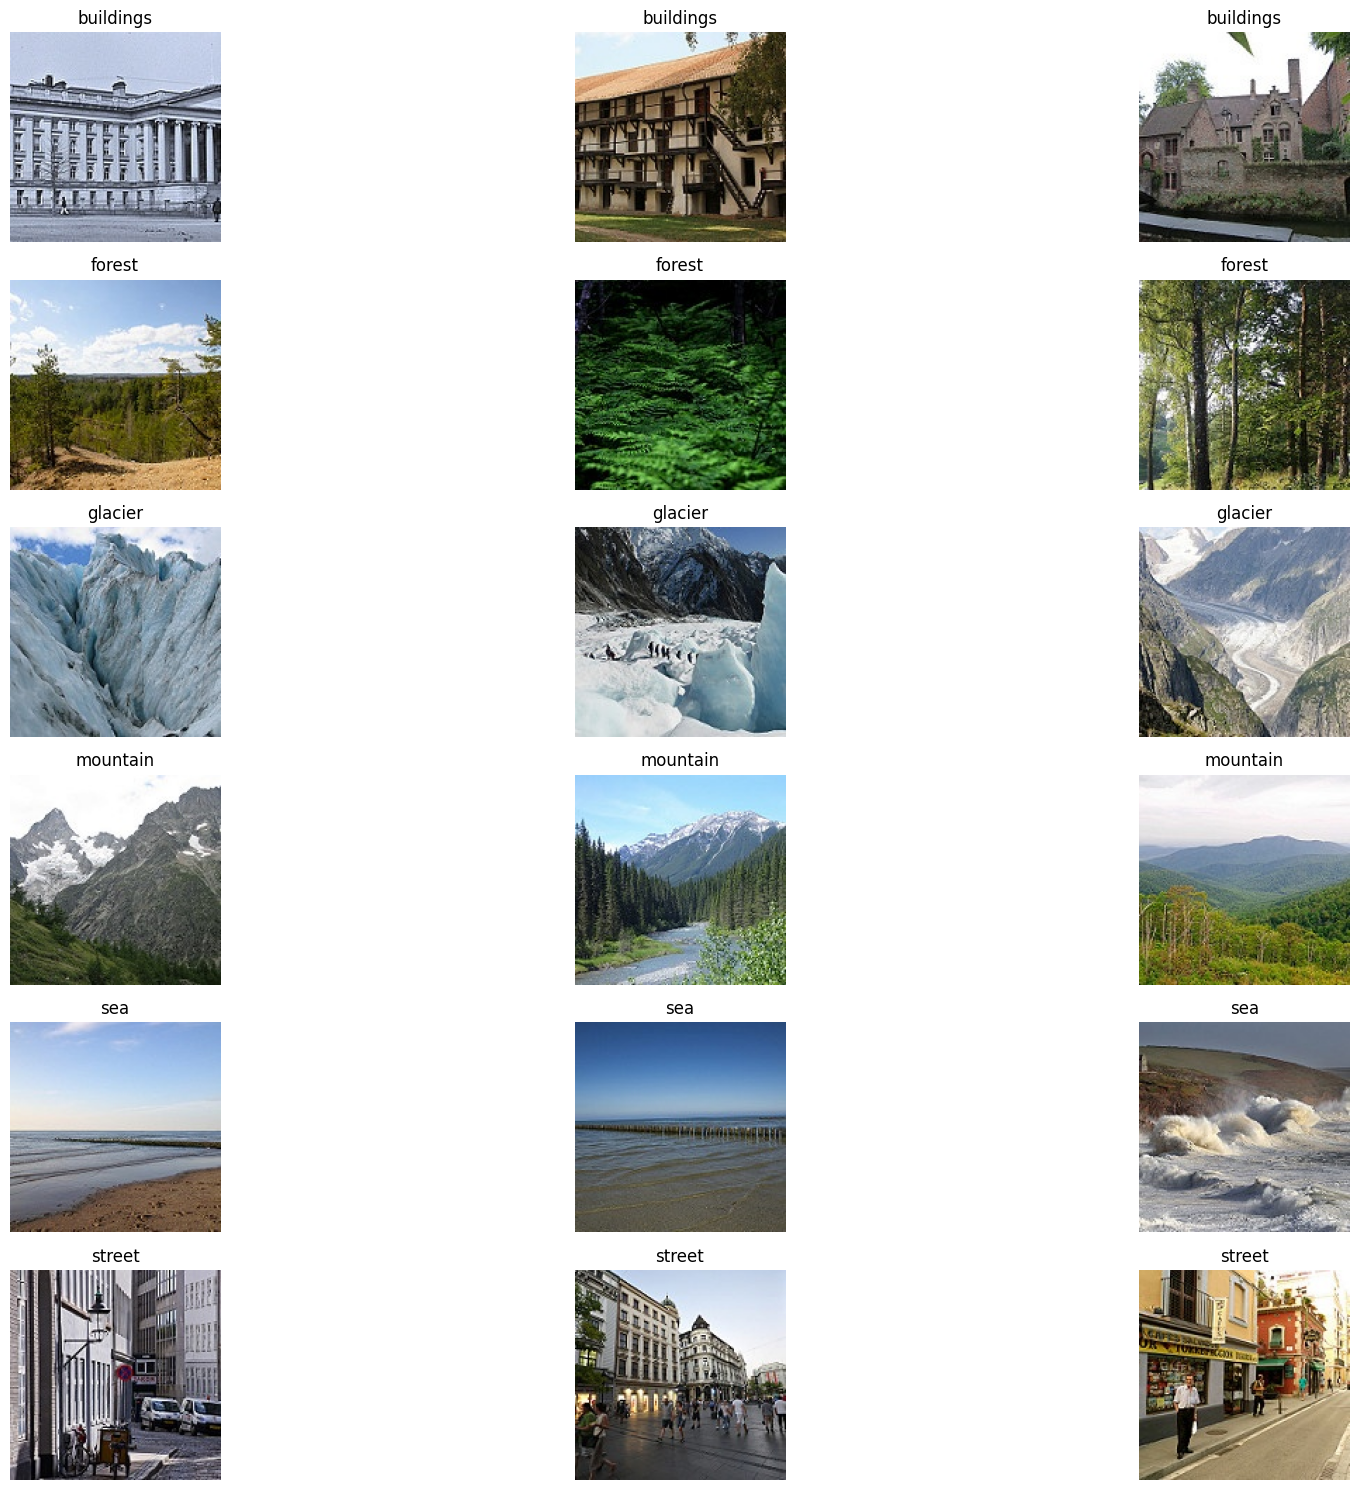

In [86]:
# Randomly printing three images from each subdirectory
fig, axs = plt.subplots(6, 3, figsize=(20, 15))  # 6 subdirectories, 3 images each

for i, subdir in enumerate(test_subdirs):
    directory = os.path.join(test_path, subdir)
    all_image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg'))]
    random_files = random.sample(all_image_files, 3)
    
    for j, file in enumerate(random_files):
        img_path = os.path.join(directory, file)
        with Image.open(img_path) as img:
            axs[i, j].imshow(img)
            axs[i, j].set_title(subdir)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

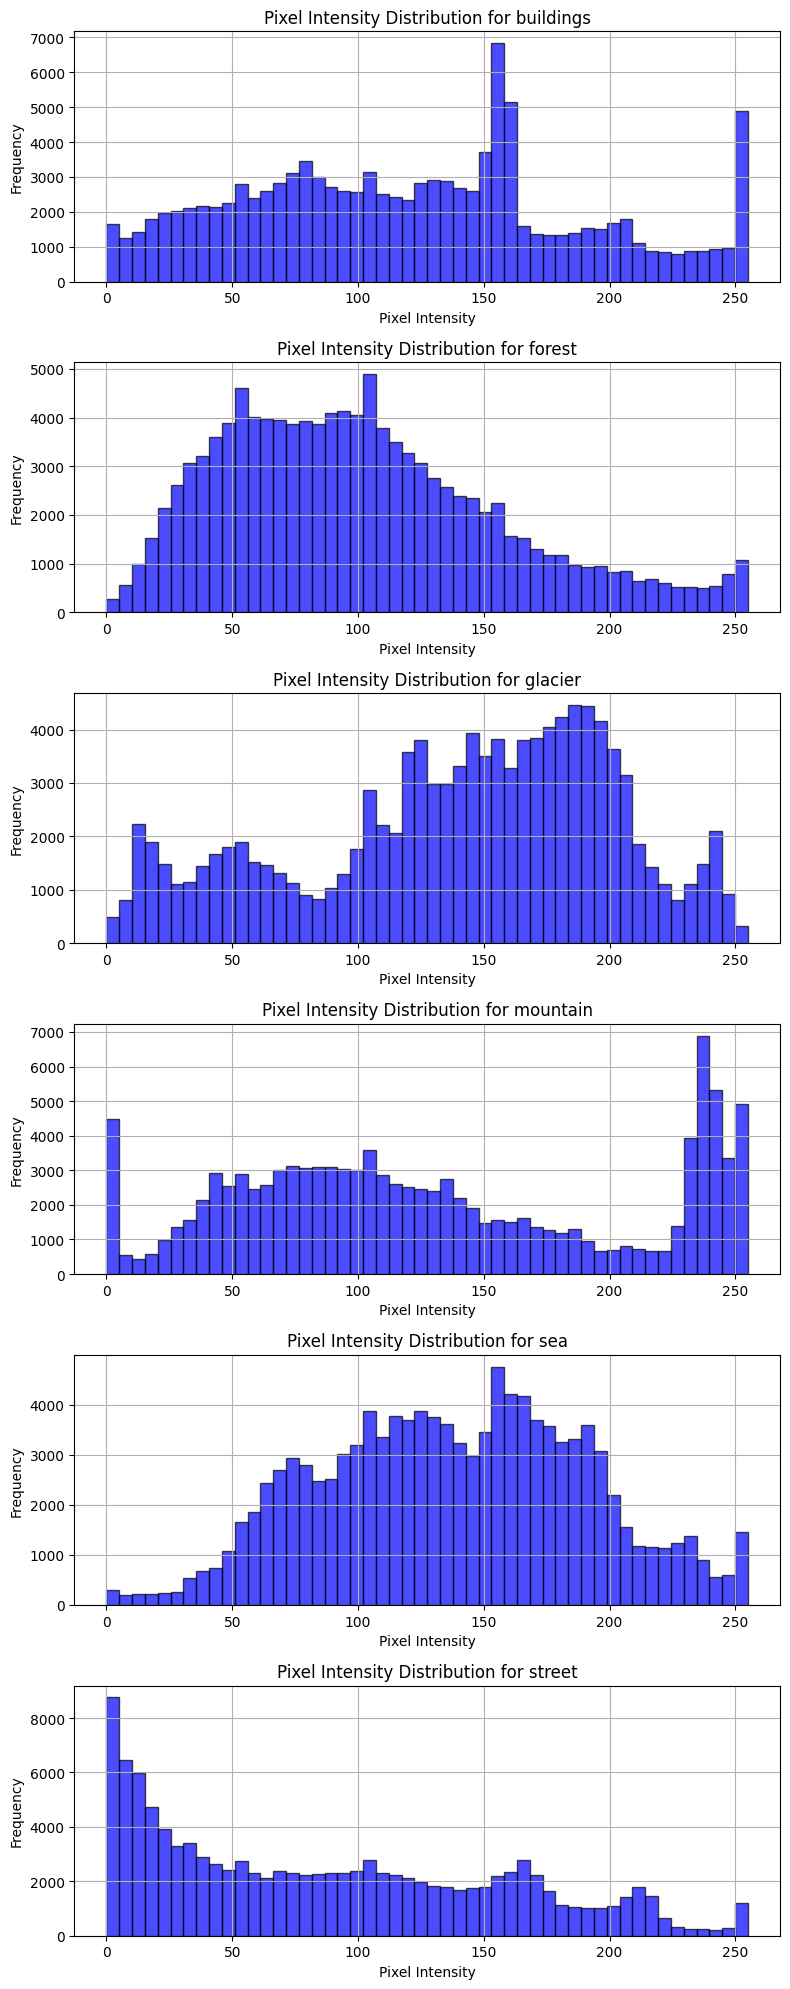

In [87]:
# Lets plot random images' pixel intensity from a directory
def get_random_image_intensity(directory, num_images=5):
    all_images = [img for img in os.listdir(directory) if img.endswith(('.jpg'))]
    selected_images = random.sample(all_images, num_images)
    intensities = []

    for img_name in selected_images:
        with Image.open(os.path.join(directory, img_name)) as img:
            img_gray = img.convert('L')  # Convert image to grayscale
            intensity = list(img_gray.getdata())
            intensities.extend(intensity)

    return intensities

# Extracting image pixel intensities from each sub-directory
image_intensities = {}
for subdir in test_subdirs:
    image_intensities[subdir] = get_random_image_intensity(os.path.join(test_path, subdir))

# Plotting the pixel intensities
fig, axs = plt.subplots(len(test_subdirs), 1, figsize=(8, 20))
for i, (subdir, intensities) in enumerate(image_intensities.items()):
    axs[i].hist(intensities, bins=50, color='blue', edgecolor='black', alpha=0.7)
    axs[i].set_title(f"Pixel Intensity Distribution for {subdir}")
    axs[i].set_xlabel('Pixel Intensity')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()



In [68]:
# Lets analyze the train sets:

train_path = "./data/dataset/train"
train_subdirs =  [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(train_path, d))]

print(f"The subdirectories within the train set are: {train_subdirs}")

The subdirectories within the train set are: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)
(150, 150, 150, 150, 150) (150, 150, 150, 150, 150)


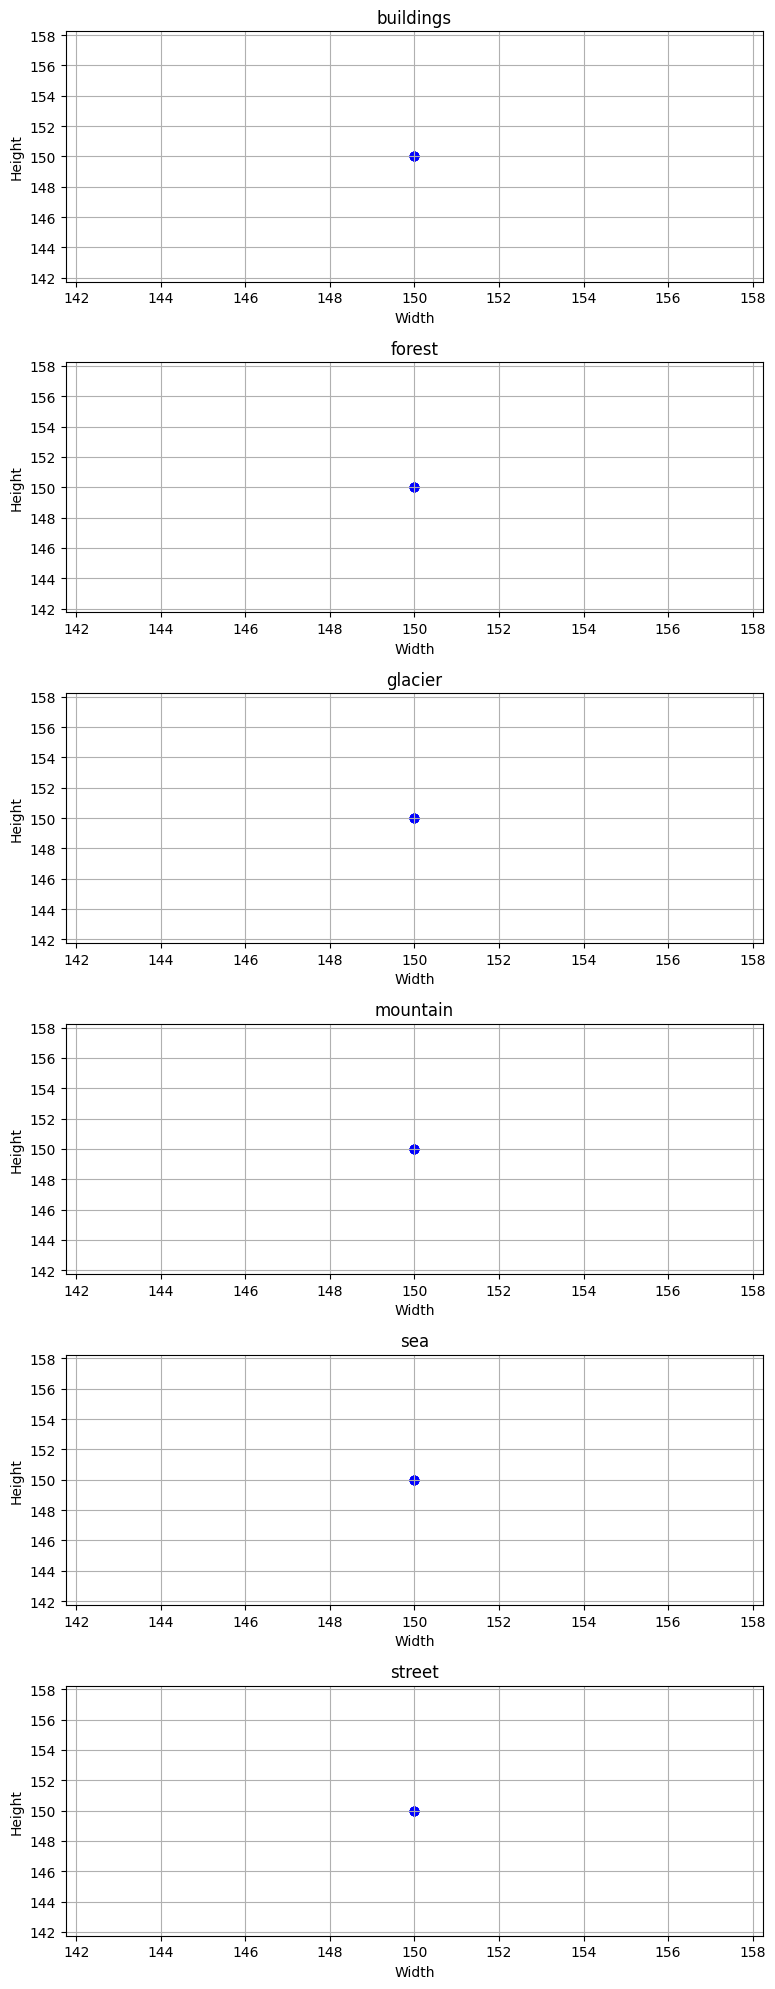

In [78]:
train_image_dimensions = {}
for subdir in train_subdirs:
    train_image_dimensions[subdir] = get_random_image_dimensions(os.path.join(train_path, subdir))

# Plotting the dimensions
fig, axs = plt.subplots(len(train_subdirs), 1, figsize=(8, 20))
for i, (subdir, dimensions) in enumerate(image_dimensions.items()):
    widths, heights = zip(*dimensions)
    print(widths, heights)
    axs[i].scatter(widths, heights, color='blue')
    axs[i].set_title(subdir)
    axs[i].set_xlabel('Width')
    axs[i].set_ylabel('Height')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

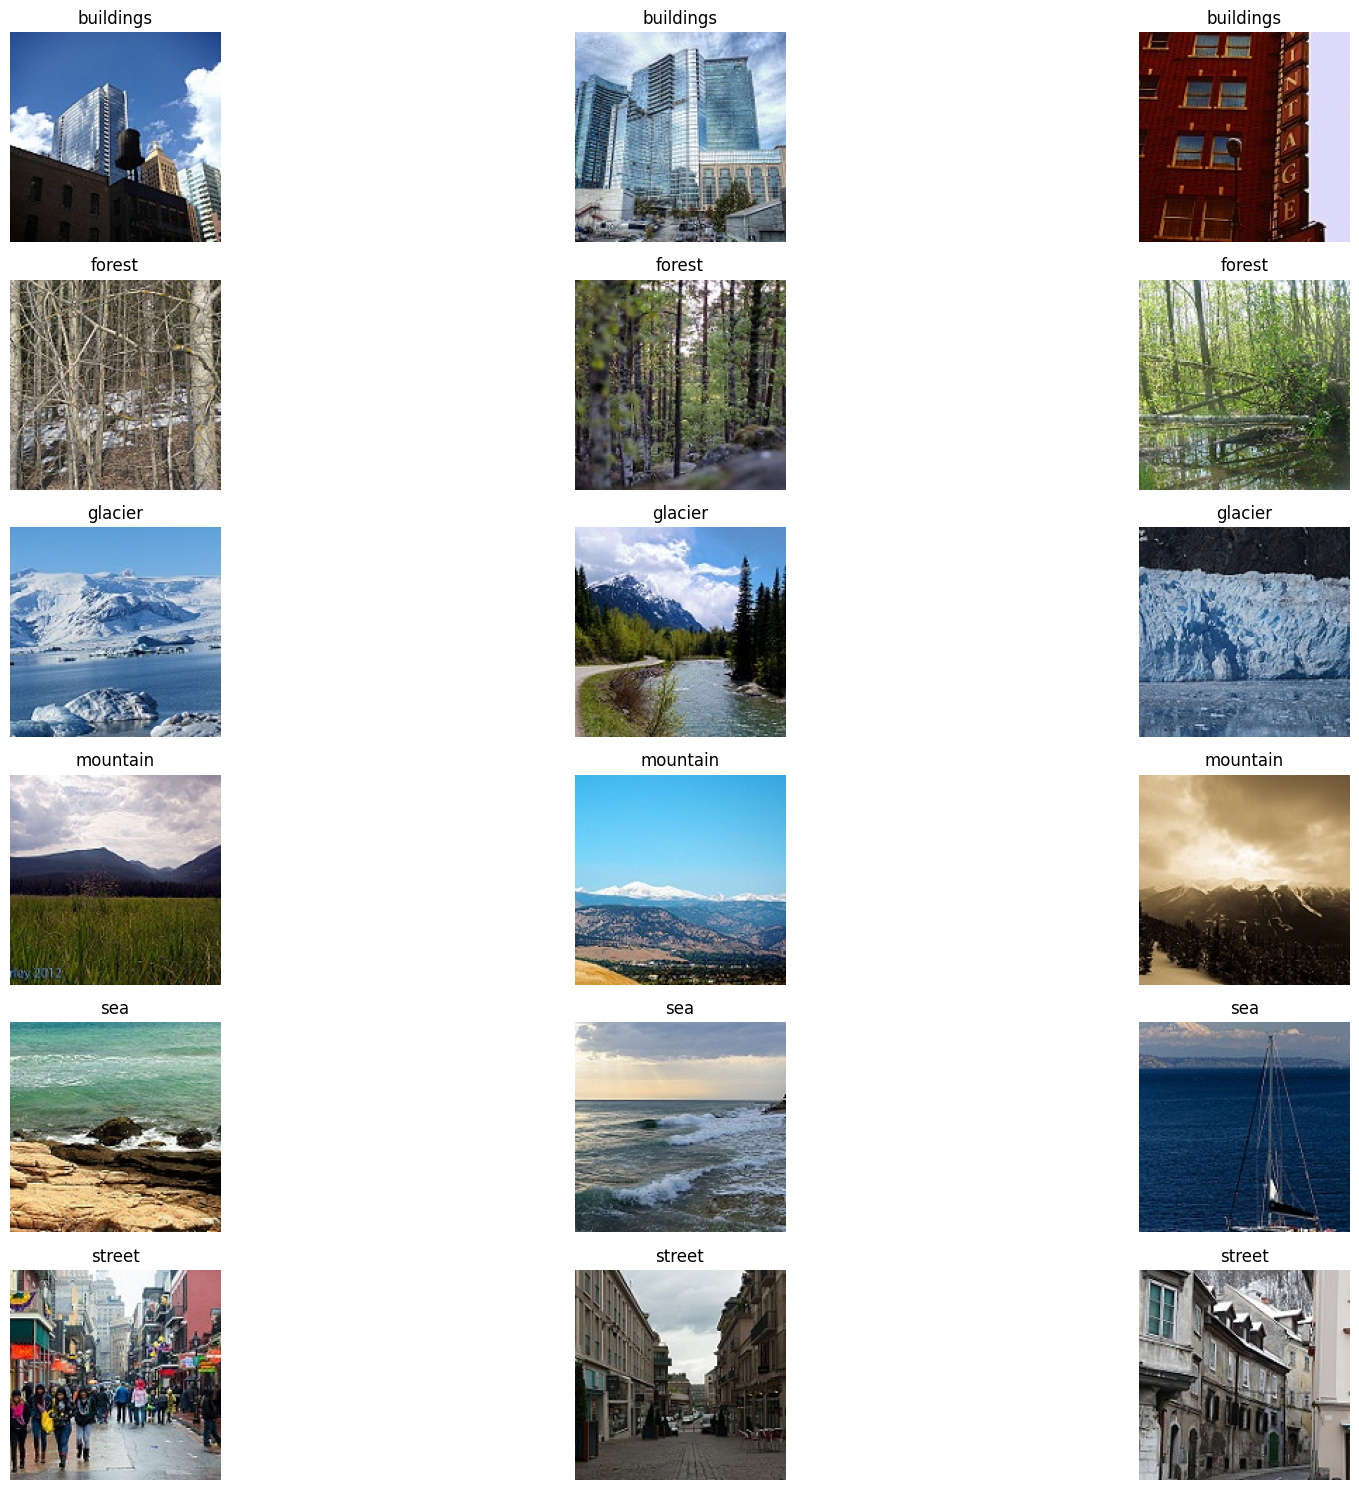

In [82]:
# Randomly printing three images from each subdirectory of the train set
fig, axs = plt.subplots(6, 3, figsize=(20, 15))  # 6 subdirectories, 3 images each

for i, subdir in enumerate(train_subdirs):
    directory = os.path.join(train_path, subdir)
    all_image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg'))]
    random_files = random.sample(all_image_files, 3)
    
    for j, file in enumerate(random_files):
        img_path = os.path.join(directory, file)
        with Image.open(img_path) as img:
            axs[i, j].imshow(img)
            axs[i, j].set_title(subdir)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

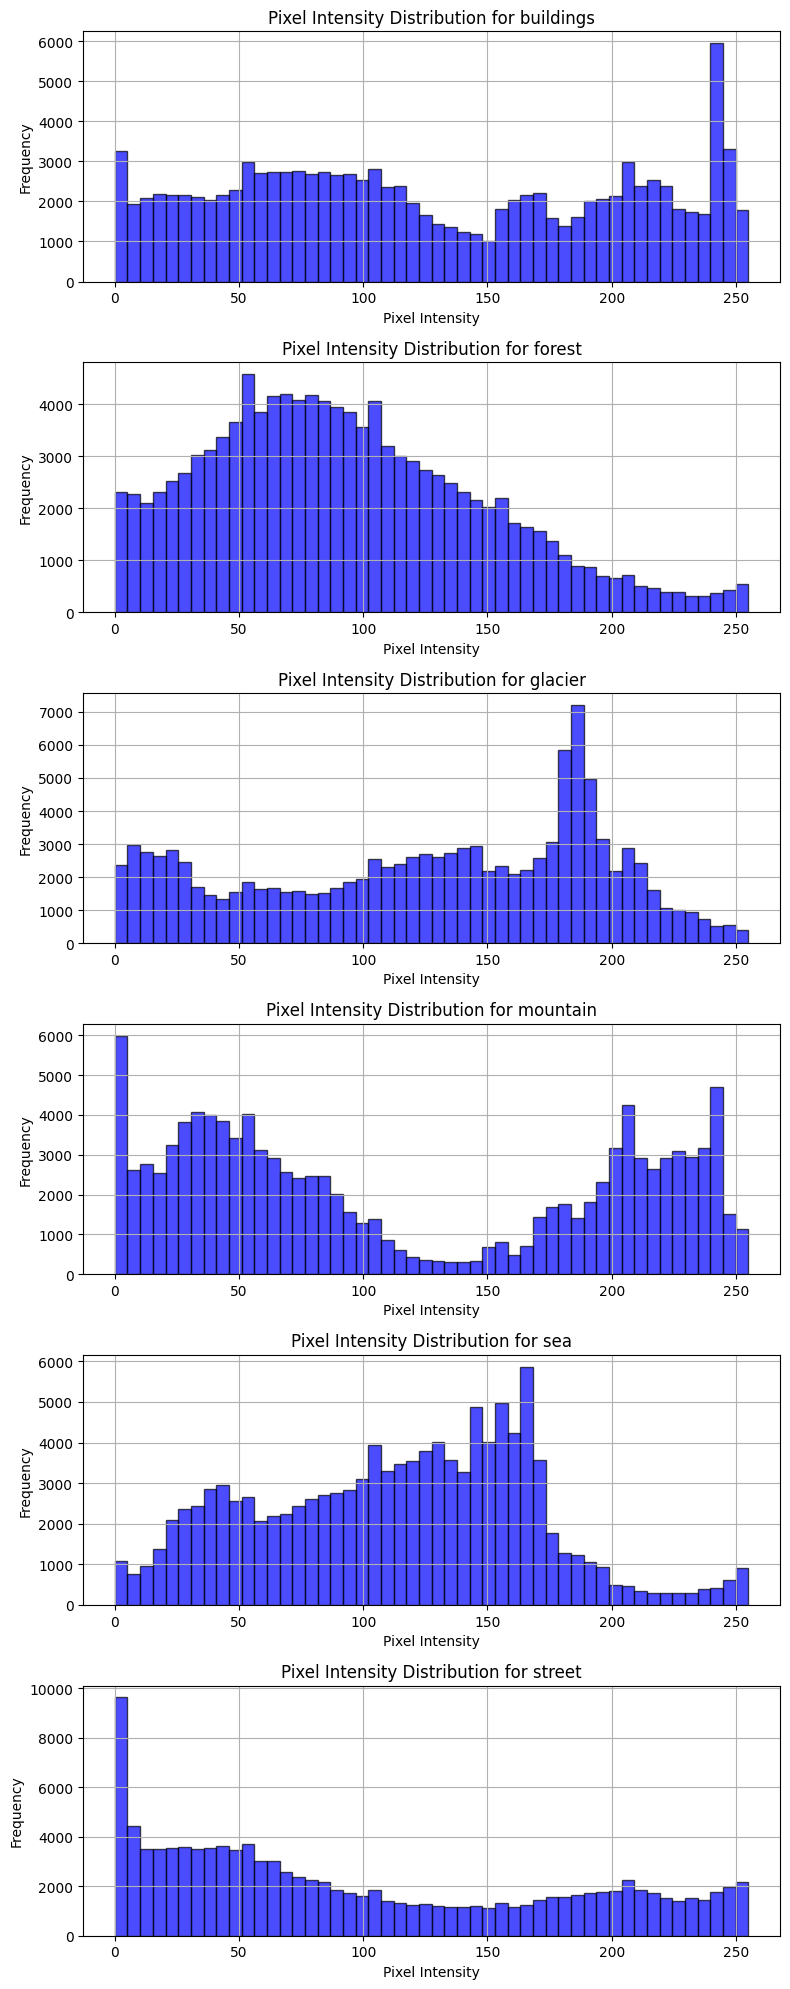

In [83]:
# Extracting image pixel intensities from each sub-directory of train folder
train_image_intensities = {}
for subdir in train_subdirs:
    train_image_intensities[subdir] = get_random_image_intensity(os.path.join(train_path, subdir))

# Plotting the pixel intensities
fig, axs = plt.subplots(len(train_subdirs), 1, figsize=(8, 20))
for i, (subdir, intensities) in enumerate(train_image_intensities.items()):
    axs[i].hist(intensities, bins=50, color='blue', edgecolor='black', alpha=0.7)
    axs[i].set_title(f"Pixel Intensity Distribution for {subdir}")
    axs[i].set_xlabel('Pixel Intensity')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


By Preprocessing images from both the train and test sets, we were able to inder that the randomly chosen images had the dimensions of 150 x 150 and this will help us in resizing our images in the subsequent steps. Since we are using the pretrained weights of a Inception V3 model, and not using the fully connected layer, we can choose to keep our images in the existing dimesnsions of 150 x 150. If we were using the fully connected layer, we would have to resize all our images to Inception V3 model's input size of 299 x 299.

We can see that the images chosen ata random are all of uniform size. 

We can also see that the pixels are widely spread out between 0 - 250  which means they have a high degrre of variablity in light. 

In [84]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

SIZE = 150

for directory_path in glob.glob("./data/dataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)



./data/dataset/train/buildings
./data/dataset/train/forest
./data/dataset/train/glacier
./data/dataset/train/mountain
./data/dataset/train/sea
./data/dataset/train/street


In [12]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("./data/dataset/test/*"):
    test_label = directory_path.split("\\")[-1]
    print(test_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(test_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

./data/dataset/test/buildings
./data/dataset/test/forest
./data/dataset/test/glacier
./data/dataset/test/mountain
./data/dataset/test/sea
./data/dataset/test/street


In [14]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [15]:
np.unique(test_labels_encoded)

array([0, 1, 2, 3, 4, 5])

In [16]:
np.unique(train_labels_encoded)

array([0, 1, 2, 3, 4, 5])

In [17]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [18]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [19]:
#Load model wothout classifier/fully connected layers
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in inception_v3.layers:
	layer.trainable = False
    
inception_v3.summary()  #Trainable parameters will be 0


2023-10-17 12:56:01.350854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 12:56:01.402347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 12:56:01.402390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 12:56:01.404238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 12:56:01.404274: I tensorflow/compile

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [20]:
#Now, let us use features from convolutional network for XGBoost
feature_extractor=inception_v3.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to XGBoost


2023-10-17 12:56:26.757002: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642140000 exceeds 10% of free system memory.
2023-10-17 12:56:28.031280: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642140000 exceeds 10% of free system memory.
2023-10-17 12:56:31.364551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904


191/191 [==============================] - 21s 65ms/step


2023-10-17 12:56:49.195792: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 736.91MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [21]:
#Send test data through same feature extractor process. i.e we need to first extract features from test data
X_test_feature = inception_v3.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

7/7 [==============================] - 3s 450ms/step


In [22]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train) #For sklearn no one hot encoding

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### 3. Perform prediction on test dataset and show prediction results

In [23]:
#Now predict using the trained XG model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

### 4. Evaluate the performance of the model.

In [26]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(le.inverse_transform(y_test), prediction))

Accuracy =  0.9952153110047847


<Axes: >

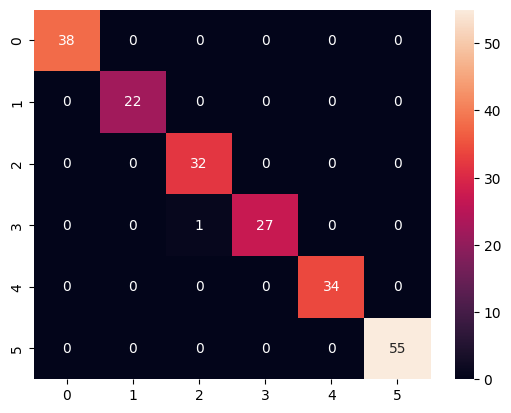

In [28]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(le.inverse_transform(y_test), prediction)
#print(cm)
sns.heatmap(cm, annot=True)

### prediction results --> continuation of 3.

1/1 [==============================] - 2s 2s/step
The prediction for this image is:  ['./data/dataset/train/sea']
The actual label for this image is:  ./data/dataset/test/sea


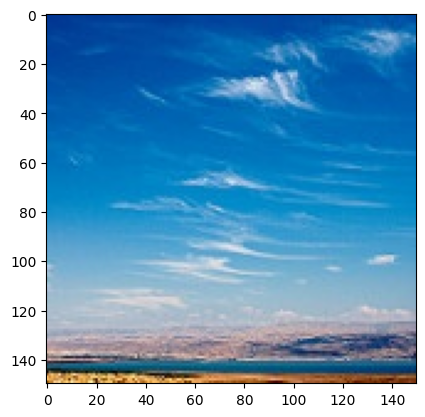

In [30]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=inception_v3.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])



### Conclusion: 
The use of pre trained weights from InceptionV3 model combined with XGboost for classification yielded an impressive model performance as evidenced by the accuracy score of 0.995 or simply 100%. The high accuracy score suggests that the xgboost classifier is adept at making correct predictions for the given classification task. The use of pretrained weights provided a significant head start for the models performance becasue Inception V3 has been trained on a large datasets like image net. 

Furthermore the images had a width and height of 150 pixels. This ensured that the model retained enough information to discern patterns like edges while also being computationally efficient. The images were also rich in colorwhich allowed the model to leverage additional channels of information which were essential for the classfication of the different landscapes we had in the dataset. The wide spread pixel intensities also helped the model understand the varied lighting conditions and details of the dataset making the model more generalizable.

While the model's performance has been nothing short of being commendable, it is essential to be on the look out for overfitting. It would be a good idea to provide the model some real world images (resized to 150 x 150) and evaluate its robustness. Nonetheless, given the choices like pre trained weights and the diversity of the dataset, the model performs extremely well for the given classification task. 



### 5. Write a paragraph on importance of Transfer Learning.
Transfer learning allows models to transfer knowledge obtained from task to another related task. It helps increase efficiency of deep learning models by eliminating the need to train the models from scratch. Training deep learning models requires significant resources which was evident from assignment 2 which required training the weights of VGG13 and Alexnet. Transfer learning allows models to bypass the training phase by frrezinf the weights from pre trained models, often trained on vas datasets which allows the model to converge faster which saves time. Transfer learning also comes in handy in situations where the data is limited. It provides a mechanism to achieve high performance on tasks with limited data by leveraging the patterns learned from related tasks with more abundant data. Transfer learning is able to this because it has already learned rich set of features fro these vast datasets like imagenet. The features often generalize well to other tasks eliminating the need to train a model from scratch. It is also versatile in that it can use knowledge from a classification task for other tasks like object detection as well to name a few. 


